In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats


import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


from fanalysis.ca import CA 
from fanalysis.mca import MCA
# Importation du fichier csv qui se trouve dans le même dossier que le notebook
data1 = pd.read_csv("analyse_personne_occupations.csv")

In [32]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6145 entries, 0 to 6144
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   fk_personne      6145 non-null   object
 1   personne         6145 non-null   object
 2   gender           6145 non-null   object
 3   zone_geo         6145 non-null   object
 4   annee_naissance  6145 non-null   int64 
 5   domaines         6145 non-null   object
 6   eff              6145 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 336.2+ KB


In [33]:
data1.head()

,fk_personne,personne,gender,zone_geo,annee_naissance,domaines,eff
0,http://www.wikidata.org/entity/Q231690,Bhimrao Ramji Ambedkar,M,Asie,1891,"ecrivain_ne,politique,enseignement,droit,SHS,S...",68
1,http://www.wikidata.org/entity/Q19526,Maya Angelou,F,Amérique du nord,1928,"cinema_TV,ecrivain_ne,politique,enseignement,a...",19
2,http://www.wikidata.org/entity/Q318509,Henry Rollins,M,Amérique du nord,1961,"cinema_TV,cinema_TV,ecrivain_ne,ecrivain_ne,ar...",18
3,http://www.wikidata.org/entity/Q1429821,Florian Mildenberger,M,Europe,1973,"SHS,SHS,SHS,SHS,enseignement,enseignement,ense...",16
4,http://www.wikidata.org/entity/Q131152,Shirin Ebadi,F,Asie,1947,"droit,ecrivain_ne,droit,politique,droit,acti_d...",16


In [34]:
data_cop = data1[data1['annee_naissance'] < 2000].copy(deep=True)
data_cop.head(3)

,fk_personne,personne,gender,zone_geo,annee_naissance,domaines,eff
0,http://www.wikidata.org/entity/Q231690,Bhimrao Ramji Ambedkar,M,Asie,1891,"ecrivain_ne,politique,enseignement,droit,SHS,S...",68
1,http://www.wikidata.org/entity/Q19526,Maya Angelou,F,Amérique du nord,1928,"cinema_TV,ecrivain_ne,politique,enseignement,a...",19
2,http://www.wikidata.org/entity/Q318509,Henry Rollins,M,Amérique du nord,1961,"cinema_TV,cinema_TV,ecrivain_ne,ecrivain_ne,ar...",18


In [108]:
### passer la dataFrame en liste

l = data_cop.values.tolist()

In [161]:
# domaine de militantisme
a = ['acti_climat', 'acti_droits_LGBT', 'acti_droits_femmes', 'acti_droits_humains']

# occupation principale. c'est à dire métier
b = ['enseignement','ecrivain_ne', 'ecrivain_ne','SHS','sciences_experimentales','sante', 'droit']

# autres occupations
c = ['cinema_TV', 'religieux_ses', 'artiste', 'feministe',  'politique', 'autre']

In [182]:
def coder(l, a, b, c):
    
    ll = []

    ## si il n'y a pas d'autres disciplines
    # complète avec disciplines principales additionnelles
   
    d= b + c
    for e in l:

        e = list(e)
        
        o1 = ''
        for el in a:
            # dès que la variable o1 est remplie sort de la boucle
            if el in e[5] and len(o1) == 0:
                o1 = el
                e.append('d1_'+ el)   
        if not(len(o1) > 0):
            e.append('d1_nr')

        o2 = ''
        for el in b:
            if el in e[5] and len(o2) == 0:
                o2 = el
                e.append('d2_'+ o2)
        if not(len(o2) > 0):
            e.append('d2_nr')


        o3 = ''
        for el in d:
            if el in e[5] and len(o3) == 0\
                    and el != o1:
                o3 = el
                e.append('d3_'+ o3)
        if not(len(o3) > 0):
            e.append('d3_nr')

        o4 = ''
        for el in c:
            if len(o4) == 0 and el in e[5]\
                    and el != o3 and el != o1:
                o4 = el
                e.append('d4_'+ o4)
        if not(len(o4) > 0):
            e.append('d4_nr')


        ll.append(e)

    return ll

# Problème
J'ai enlevé le droit de la colonne comme il prenait beaucoup plus de place que ce qui existe dans la base de donnée ?? pourquoi ?

In [183]:
ll = coder(l, a, b, c)

In [184]:
pprint.pprint(ll[70:79])

[['http://www.wikidata.org/entity/Q103591',
  'Germaine Greer',
  'F',
  'Océanie',
  1939,
  'cinema_TV,cinema_TV,ecrivain_ne,enseignement,enseignement,ecrivain_ne,autre,ecrivain_ne,autre,acti_droits_femmes,feministe',
  11,
  'd1_acti_droits_femmes',
  'd2_enseignement',
  'd3_enseignement',
  'd4_cinema_TV'],
 ['http://www.wikidata.org/entity/Q80900',
  'Pearl S. Buck',
  'F',
  'Amérique du nord',
  1892,
  'cinema_TV,ecrivain_ne,religieux_ses,ecrivain_ne,acti_droits_humains,ecrivain_ne,ecrivain_ne,ecrivain_ne,ecrivain_ne,ecrivain_ne',
  10,
  'd1_acti_droits_humains',
  'd2_ecrivain_ne',
  'd3_ecrivain_ne',
  'd4_cinema_TV'],
 ['http://www.wikidata.org/entity/Q75154532',
  'Oscar Soria',
  'M',
  'Amérique du sud',
  1974,
  'acti_droits_humains,ecrivain_ne,autre,acti_climat,acti_climat,acti_droits_humains,ecrivain_ne,autre,acti_climat,acti_climat',
  10,
  'd1_acti_climat',
  'd2_ecrivain_ne',
  'd3_ecrivain_ne',
  'd4_autre'],
 ['http://www.wikidata.org/entity/Q73733144',
  'Rod

In [185]:
len(l),len(ll), ll[301:305]

(6145,
 6145,
 [['http://www.wikidata.org/entity/Q5386557',
   'Eric Garcetti',
   'M',
   'Amérique du nord',
   1971,
   'SHS,autre,cinema_TV,acti_climat,cinema_TV,politique,enseignement',
   7,
   'd1_acti_climat',
   'd2_enseignement',
   'd3_enseignement',
   'd4_cinema_TV'],
  ['http://www.wikidata.org/entity/Q5376037',
   'Waleed Al-Husseini',
   'M',
   'Asie ',
   1989,
   'ecrivain_ne,enseignement,autre,SHS,autre,ecrivain_ne,acti_droits_femmes',
   7,
   'd1_acti_droits_femmes',
   'd2_enseignement',
   'd3_enseignement',
   'd4_autre'],
  ['http://www.wikidata.org/entity/Q5253877',
   'Delia Grigore',
   'F',
   'Europe',
   1972,
   'ecrivain_ne,acti_droits_humains,enseignement,ecrivain_ne,SHS,SHS,SHS',
   7,
   'd1_acti_droits_humains',
   'd2_enseignement',
   'd3_enseignement',
   'd4_nr'],
  ['http://www.wikidata.org/entity/Q5248365',
   'Deborah L. Rhode',
   'F',
   'Amérique du nord',
   1952,
   'ecrivain_ne,droit,enseignement,enseignement,SHS,acti_droits_femmes,ens

In [186]:
df_ll = pd.DataFrame(ll, columns=['uri', 'nom', 'genre', 'origine_geo', 'annee_nais',
                      'liste_occup', 'eff_occupations', 'o1', 'o2', 'o3', 'o4'])
df_ll.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6145 entries, 0 to 6144
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   uri              6145 non-null   object
 1   nom              6145 non-null   object
 2   genre            6145 non-null   object
 3   origine_geo      6145 non-null   object
 4   annee_nais       6145 non-null   int64 
 5   liste_occup      6145 non-null   object
 6   eff_occupations  6145 non-null   int64 
 7   o1               6145 non-null   object
 8   o2               6145 non-null   object
 9   o3               6145 non-null   object
 10  o4               6145 non-null   object
dtypes: int64(2), object(9)
memory usage: 528.2+ KB


In [187]:
df_ll.groupby(by='o1').size().sort_values(ascending=False)

o1
d1_acti_droits_humains    2517
d1_acti_droits_femmes     2295
d1_acti_droits_LGBT       1106
d1_acti_climat             227
dtype: int64

In [189]:
## le résultat est faux, je ne pense pas qu'autant de monde fait du droit --> revoir dans la base de donnée.
df_ll.groupby(by='o4').size().sort_values(ascending=False)


o4
d4_nr               3231
d4_politique        1375
d4_autre             460
d4_cinema_TV         430
d4_artiste           311
d4_feministe         239
d4_religieux_ses      99
dtype: int64

In [190]:
### Année minimale et maximale dans la population
min(df_ll['annee_nais']), max(df_ll['annee_nais'])

(1816, 1999)

In [191]:
l_25 = list(range(1816, 2017, 25))
l_25 [:5], l_25[-5:]

([1816, 1841, 1866, 1891, 1916], [1916, 1941, 1966, 1991, 2016])

In [192]:
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_ll['periodes'] = pd.cut(df_ll['annee_nais'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_ll['periodes'] = df_ll['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_ll.head(3)

,uri,nom,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes
0,http://www.wikidata.org/entity/Q231690,Bhimrao Ramji Ambedkar,M,Asie,1891,"ecrivain_ne,politique,enseignement,droit,SHS,S...",68,d1_acti_droits_femmes,d2_enseignement,d3_enseignement,d4_religieux_ses,1891-1915
1,http://www.wikidata.org/entity/Q19526,Maya Angelou,F,Amérique du nord,1928,"cinema_TV,ecrivain_ne,politique,enseignement,a...",19,d1_acti_droits_humains,d2_enseignement,d3_enseignement,d4_cinema_TV,1916-1940
2,http://www.wikidata.org/entity/Q318509,Henry Rollins,M,Amérique du nord,1961,"cinema_TV,cinema_TV,ecrivain_ne,ecrivain_ne,ar...",18,d1_acti_droits_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_cinema_TV,1941-1965


In [193]:
df_ll.tail()

,uri,nom,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes
6140,http://www.wikidata.org/entity/Q101982314,Vernon Gonsalves,M,Asie,1957,acti_droits_humains,1,d1_acti_droits_humains,d2_droit,d3_droit,d4_nr,1941-1965
6141,http://www.wikidata.org/entity/Q101612226,Sisto dos Santos,M,Asie,1979,acti_droits_humains,1,d1_acti_droits_humains,d2_droit,d3_droit,d4_nr,1966-1990
6142,http://www.wikidata.org/entity/Q100742096,Thea Wickel,LGBTQ,Europe,1923,acti_droits_LGBT,1,d1_acti_droits_LGBT,d2_droit,d3_droit,d4_nr,1916-1940
6143,http://www.wikidata.org/entity/Q1006271,Thich Huyen Quang,M,Asie,1919,acti_droits_humains,1,d1_acti_droits_humains,d2_droit,d3_droit,d4_nr,1916-1940
6144,http://www.wikidata.org/entity/Q100411437,Alison Gent,F,Océanie,1920,acti_droits_femmes,1,d1_acti_droits_femmes,d2_droit,d3_droit,d4_nr,1916-1940


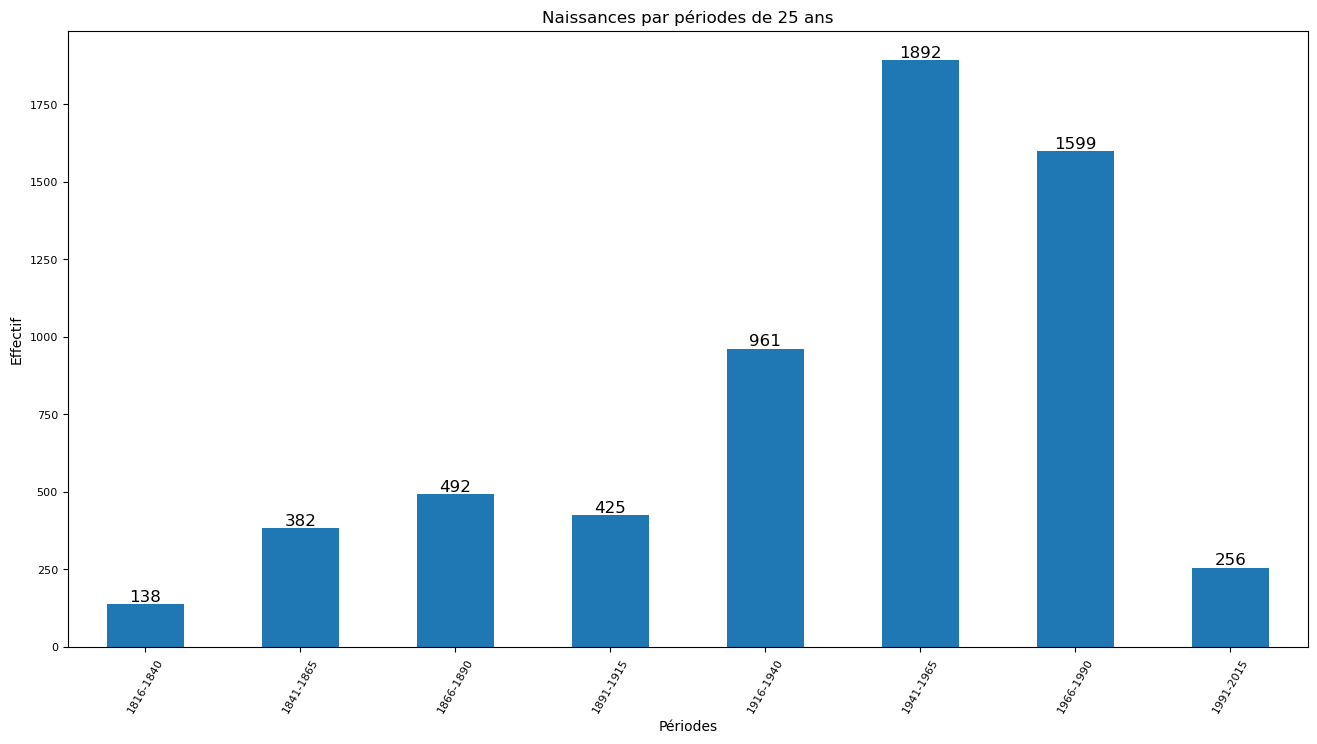

In [194]:
### compter les naissances par périodes de 50 ans
ax = df_ll.groupby(by='periodes', observed=True).size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
ax.bar_label(ax.containers[0], fontsize=12)

plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de 25 ans')
plt.show()

Pour garder de la cohérence nous allons analyser que les personnes qui ont vécu lors du 20ème siècle

In [197]:
### On notera l'effectif trop important des individus pour lesquels cette variable
# n'est pas renseignée. Mieux vaudra ne pas l'utiliser
df_d2 = df_ll[df_ll.annee_nais > 1890].groupby(by='o2').size().sort_values(ascending=False)
df_d2

o2
d2_droit                      2710
d2_ecrivain_ne                1314
d2_enseignement                594
d2_SHS                         250
d2_sciences_experimentales     107
d2_sante                        85
d2_nr                           73
dtype: int64

# Le problème avec le droit ?

In [198]:
l_d2 = df_d2.index.to_list()[:-2]
print(l_d2)

['d2_droit', 'd2_ecrivain_ne', 'd2_enseignement', 'd2_SHS', 'd2_sciences_experimentales']


In [199]:
df_d3 = df_ll[df_ll.annee_nais > 1890].groupby(by='o3').size().sort_values(ascending=False)
df_d3

o3
d3_droit                      2710
d3_ecrivain_ne                1314
d3_enseignement                594
d3_SHS                         250
d3_sciences_experimentales     107
d3_sante                        85
d3_nr                           34
d3_politique                    13
d3_artiste                       9
d3_autre                         7
d3_cinema_TV                     7
d3_feministe                     2
d3_religieux_ses                 1
dtype: int64

In [203]:
## j'enlève la santé et quand c'est pas renseigné.
l_d3 = df_d3.index.to_list()[:-7]
print(l_d3)

['d3_droit', 'd3_ecrivain_ne', 'd3_enseignement', 'd3_SHS', 'd3_sciences_experimentales', 'd3_sante']


In [204]:
df_d4 = df_ll[df_ll.annee_nais > 1890].groupby(by='o4').size().sort_values(ascending=False)
df_d4

o4
d4_nr               2776
d4_politique        1175
d4_cinema_TV         410
d4_autre             376
d4_artiste           259
d4_religieux_ses      85
d4_feministe          52
dtype: int64

## moitié pas renseignée j'abandonne cette donnée ?
Ici faut voir avec le prof

In [276]:
df_ll[df_ll.annee_nais > 1889].groupby(by='periodes', observed=True).size().sort_values(ascending=False)

periodes
1941-1965    1892
1966-1990    1599
1916-1940     961
1891-1915     425
1991-2015     256
1866-1890      21
dtype: int64

In [277]:
cdf_og = df_ll[df_ll.annee_nais > 1890].groupby(by='origine_geo', observed=True).size().sort_values(ascending=False)
cdf_og

origine_geo
Europe              1849
Amérique du nord     982
Asie                 961
Amérique du sud      709
Afrique              507
Océanie              125
dtype: int64

In [278]:
l_og = cdf_og.index.to_list()[:-1]
print(l_og)

['Europe', 'Amérique du nord', 'Asie ', 'Amérique du sud', 'Afrique']


## Préparer le tableau à analyser

Il est nécessaire de recoder le tableau pour ne pas avoir des variables avec modalités vides: on utilise donc un nouveau tableau avec les individus nés après 1890.

Aussi, si on n'enlève pas les modalités les moins fréquentes (cf. distributions ci-dessus) elles impactent massivement l'analyse factorielle des correspondances multiples, car les modalités les moins fréquentes apportent le plus de variation. On doit donc inspecter manuellement les profils rares mais les exclure de l'ACM pour mettre en évidence des structures plus importantes.

In [304]:
### Créer une copie indépendante du DataFrame 
# tout en éliminant les modalités peu fréquentes 
cdf_mod = df_ll[(df_ll['annee_nais'] > 1890)\
                & (df_ll.origine_geo.isin(l_og))\
                & (df_ll.o2.isin(l_d2))\
                & (df_ll.o3.isin(l_d3))]\
                    .copy(deep=True).reset_index(names='orig_index')
print(len(cdf_mod))
cdf_mod.head(3)

4855


,orig_index,uri,nom,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes
0,0,http://www.wikidata.org/entity/Q231690,Bhimrao Ramji Ambedkar,M,Asie,1891,"ecrivain_ne,politique,enseignement,droit,SHS,S...",68,d1_acti_droits_femmes,d2_enseignement,d3_enseignement,d4_religieux_ses,1891-1915
1,1,http://www.wikidata.org/entity/Q19526,Maya Angelou,F,Amérique du nord,1928,"cinema_TV,ecrivain_ne,politique,enseignement,a...",19,d1_acti_droits_humains,d2_enseignement,d3_enseignement,d4_cinema_TV,1916-1940
2,2,http://www.wikidata.org/entity/Q318509,Henry Rollins,M,Amérique du nord,1961,"cinema_TV,cinema_TV,ecrivain_ne,ecrivain_ne,ar...",18,d1_acti_droits_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_cinema_TV,1941-1965


In [305]:
cdf_mod.tail()

,orig_index,uri,nom,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes
4850,6137,http://www.wikidata.org/entity/Q102282163,Nadeen Ashraf,F,Afrique,1998,acti_droits_femmes,1,d1_acti_droits_femmes,d2_droit,d3_droit,d4_nr,1991-2015
4851,6140,http://www.wikidata.org/entity/Q101982314,Vernon Gonsalves,M,Asie,1957,acti_droits_humains,1,d1_acti_droits_humains,d2_droit,d3_droit,d4_nr,1941-1965
4852,6141,http://www.wikidata.org/entity/Q101612226,Sisto dos Santos,M,Asie,1979,acti_droits_humains,1,d1_acti_droits_humains,d2_droit,d3_droit,d4_nr,1966-1990
4853,6142,http://www.wikidata.org/entity/Q100742096,Thea Wickel,LGBTQ,Europe,1923,acti_droits_LGBT,1,d1_acti_droits_LGBT,d2_droit,d3_droit,d4_nr,1916-1940
4854,6143,http://www.wikidata.org/entity/Q1006271,Thich Huyen Quang,M,Asie,1919,acti_droits_humains,1,d1_acti_droits_humains,d2_droit,d3_droit,d4_nr,1916-1940


In [306]:
## max d'individus
max(cdf_mod.index)

4854

In [311]:
### Année minimale et maximale dans la population
min(cdf_mod['annee_nais']), max(cdf_mod['annee_nais'])

(1891, 1999)

In [313]:
### Créer une liste d'années pour séparer en périodes de 20 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_20 = list(range(1891, 2021, 20))
l_20[:5],l_20[-5:]

([1891, 1911, 1931, 1951, 1971], [1931, 1951, 1971, 1991, 2011])

In [316]:

cdf_mod['periodes_20'] = pd.cut(cdf_mod['annee_nais'], l_20, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_mod['periodes_20'] = cdf_mod['periodes_20'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_mod.head(3)

,orig_index,uri,nom,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes,periodes_20
0,0,http://www.wikidata.org/entity/Q231690,Bhimrao Ramji Ambedkar,M,Asie,1891,"ecrivain_ne,politique,enseignement,droit,SHS,S...",68,d1_acti_droits_femmes,d2_enseignement,d3_enseignement,d4_religieux_ses,1891-1915,1891-1910
1,1,http://www.wikidata.org/entity/Q19526,Maya Angelou,F,Amérique du nord,1928,"cinema_TV,ecrivain_ne,politique,enseignement,a...",19,d1_acti_droits_humains,d2_enseignement,d3_enseignement,d4_cinema_TV,1916-1940,1911-1930
2,2,http://www.wikidata.org/entity/Q318509,Henry Rollins,M,Amérique du nord,1961,"cinema_TV,cinema_TV,ecrivain_ne,ecrivain_ne,ar...",18,d1_acti_droits_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_cinema_TV,1941-1965,1951-1970


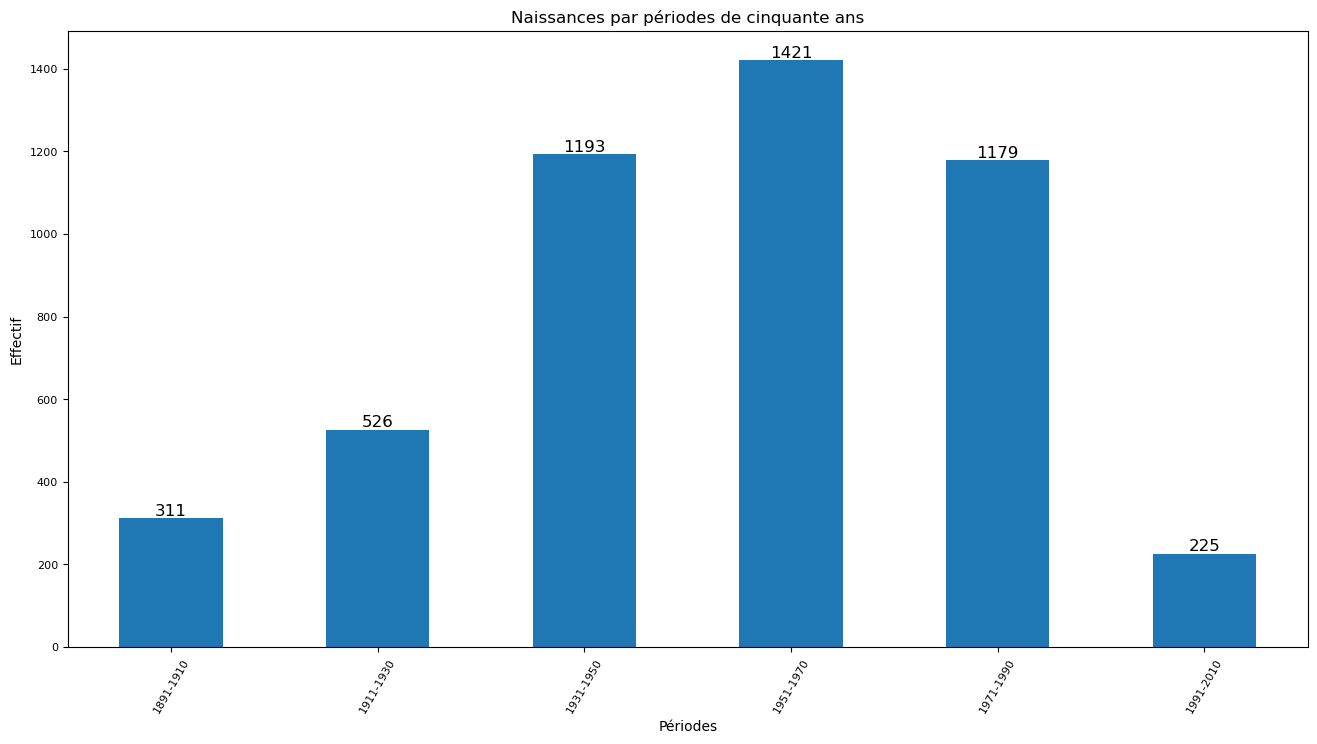

In [317]:
ax = cdf_mod.groupby(by='periodes_20', observed=True).size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
ax.bar_label(ax.containers[0], fontsize=12)

plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de cinquante ans')
plt.show()

In [318]:
DActives = cdf_mod[['periodes_20', 'origine_geo',
 'o1', 'o2', 'o3']].copy(deep=True)

In [320]:
## période avant 20ème pas enlevée on verra si c'est grave
DActives.groupby(by='periodes_20', observed=False).size()

periodes_20
1891-1910     311
1911-1930     526
1931-1950    1193
1951-1970    1421
1971-1990    1179
1991-2010     225
dtype: int64

In [321]:
### Structure du tableau à analyser
# nombre de variables
p = DActives.shape[1]
# nombre d'observations
n = DActives.shape[0]
print('Nombre variables:', p, 'Nombre lignes:', n)
# codage en 0/1
X = pd.get_dummies(DActives,prefix='',prefix_sep='')*1

Nombre variables: 5 Nombre lignes: 4855


### Distance des individus par rapport au profil moyen

In [322]:
#Calcul du profil de l'individu moyen
ind_moy = np.sum(X.values,axis=0)/(n*p)
print(ind_moy)

[0.01281153 0.02166838 0.04914521 0.05853759 0.04856849 0.0092688
 0.01932029 0.03938208 0.0284655  0.0384758  0.07435633 0.00568486
 0.0430484  0.05396498 0.09730175 0.01005149 0.10904222 0.05301751
 0.02360453 0.00428424 0.01005149 0.10904222 0.05301751 0.02360453
 0.00428424]


In [323]:
### Ajouter une colonne avec la distance chi-2 de chaque individu par rapport à l'individu moyen
# pour chaque individu: les individus plus éloignés sont plus rares
X['dist_org'] = X.apply(lambda x: round(np.sum(1/ind_moy*(x/p-ind_moy)**2),4), raw=True, axis=1)

In [324]:
### Inspecter le tableau
X.sort_values(by='dist_org', ascending=False).head(10)['dist_org']

1401    31.0952
1992    31.0952
2433    29.5628
1690    27.6033
750     26.9381
519     26.7978
298     26.5486
3393    26.5486
2597    26.5389
1745    26.5389
Name: dist_org, dtype: float64

count    4855.000000
mean        4.000001
std         3.434630
min         1.366000
25%         2.197800
50%         2.858800
75%         4.512300
max        31.095200
Name: dist_org, dtype: float64


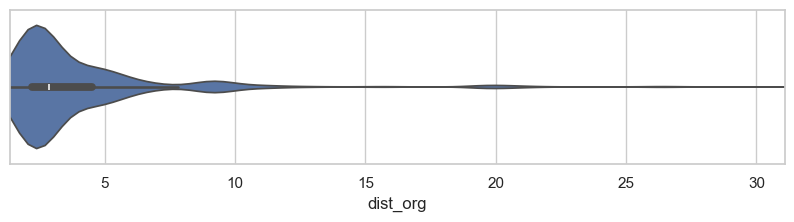

In [325]:
### Distribution de la distance chi-2

sns.set_theme(style="whitegrid",rc={"figure.figsize":(10,2)} )


a = X['dist_org']
# a = X['dist_org'][X['dist_org']< 20]

print(a.describe())

ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=min(a), right=max(a))

plt.show()

In [326]:
### Ajouter la distance des individus à leur données
# On créé un nouveau DataFrame qui résulte de la jointure des deux précédents
cdf_mod_dist= pd.merge(cdf_mod, X.dist_org, left_index=True, right_index=True)
cdf_mod_dist[:3]

,orig_index,uri,nom,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes,periodes_20,dist_org
0,0,http://www.wikidata.org/entity/Q231690,Bhimrao Ramji Ambedkar,M,Asie,1891,"ecrivain_ne,politique,enseignement,droit,SHS,S...",68,d1_acti_droits_femmes,d2_enseignement,d3_enseignement,d4_religieux_ses,1891-1915,1891-1910,7.2922
1,1,http://www.wikidata.org/entity/Q19526,Maya Angelou,F,Amérique du nord,1928,"cinema_TV,ecrivain_ne,politique,enseignement,a...",19,d1_acti_droits_humains,d2_enseignement,d3_enseignement,d4_cinema_TV,1916-1940,1911-1930,5.6620
2,2,http://www.wikidata.org/entity/Q318509,Henry Rollins,M,Amérique du nord,1961,"cinema_TV,cinema_TV,ecrivain_ne,ecrivain_ne,ar...",18,d1_acti_droits_humains,d2_ecrivain_ne,d3_ecrivain_ne,d4_cinema_TV,1941-1965,1951-1970,2.6190


In [327]:
## Individus proches du profil moyen
#  donc fréquents
df_filtered = cdf_mod_dist[cdf_mod_dist.dist_org<2]
print(len(df_filtered))
df_filtered.sort_values(by='dist_org')[:5]

878


,orig_index,uri,nom,genre,origine_geo,annee_nais,liste_occup,eff_occupations,o1,o2,o3,o4,periodes,periodes_20,dist_org
4689,5943,http://www.wikidata.org/entity/Q15815037,Dunja Mijatović,F,Europe,1964,acti_droits_humains,1,d1_acti_droits_humains,d2_droit,d3_droit,d4_nr,1941-1965,1951-1970,1.366
4651,5898,http://www.wikidata.org/entity/Q16206950,Shane Ryan,M,Europe,1969,acti_droits_humains,1,d1_acti_droits_humains,d2_droit,d3_droit,d4_nr,1966-1990,1951-1970,1.366
4100,5265,http://www.wikidata.org/entity/Q5993645,Igor Rotar,M,Europe,1965,acti_droits_humains,1,d1_acti_droits_humains,d2_droit,d3_droit,d4_nr,1941-1965,1951-1970,1.366
4726,5985,http://www.wikidata.org/entity/Q1249140,Monika Lüke,F,Europe,1969,acti_droits_humains,1,d1_acti_droits_humains,d2_droit,d3_droit,d4_nr,1966-1990,1951-1970,1.366
1829,2414,http://www.wikidata.org/entity/Q440597,Oswaldo Payá,M,Europe,1952,"politique,acti_droits_humains,autre",3,d1_acti_droits_humains,d2_droit,d3_droit,d4_politique,1941-1965,1951-1970,1.366


In [330]:
## Inspecter les combinaisons les plus fréquentes
cdf_mod_dist.groupby(by=['periodes_20','origine_geo','o1','o2','o3'],\
                       observed=True).size().sort_values(ascending=False).head(10)

periodes_20  origine_geo      o1                      o2              o3            
1951-1970    Asie             d1_acti_droits_humains  d2_droit        d3_droit          160
1971-1990    Asie             d1_acti_droits_humains  d2_droit        d3_droit          138
             Europe           d1_acti_droits_humains  d2_droit        d3_droit           93
1951-1970    Europe           d1_acti_droits_humains  d2_droit        d3_droit           92
                              d1_acti_droits_LGBT     d2_droit        d3_droit           86
1931-1950    Asie             d1_acti_droits_humains  d2_droit        d3_droit           83
             Europe           d1_acti_droits_humains  d2_droit        d3_droit           79
1971-1990    Europe           d1_acti_droits_LGBT     d2_droit        d3_droit           77
1951-1970    Amérique du sud  d1_acti_droits_humains  d2_droit        d3_droit           76
1931-1950    Europe           d1_acti_droits_humains  d2_ecrivain_ne  d3_ecrivain_ne   